<center> <h2> DS 3000 - Fall 2020</h2> </center>
<center> <h3> DS Report </h3> </center>


<center> <h3>Chess Game Analysis and Winner Prediction</h3> </center>
<center><h4>Fletcher Hubsch, Charlie Morgan</h4></center>


<hr style="height:2px; border:none; color:black; background-color:black;">

#### Executive Summary:

For our project we collected data from the Lichess.org database to determine if opening evaluation (that is how good a player is doing in the opening) corresponded to victory. We started by collecting the data and then using the game links inside to scrap the data and used the stockfish api to get a computational score of the game. We then cleaned our data and derived other key features to make our predictions. From there we used one-hot encoder to fit our data before using the KNN, Decision Tree, and Naïve Bayesian classifiers. We found KNN and Decision Tree to be best so we optimized it with GridSearch before testing it. We found it to be an accurate predictor of victory and used an F1 score to confirm its significance. 


<hr style="height:2px; border:none; color:black; background-color:black;">

## Outline
1. <a href='#1'>INTRODUCTION</a>
2. <a href='#2'>METHOD</a>
3. <a href='#3'>RESULTS</a>
4. <a href='#4'>DISCUSSION</a>

<a id="1"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 1. INTRODUCTION

#### Problem Statement
* In our project, we examine the relationship between opening evaluation and victory in the game of Chess. We go on to also examine the ways in which player elo (elo being a relative metric in which players are rated) may also affect that result in conjunction to opening evaluation. The game of chess predates these sorts of computations and has accrued a massive library of wisdom. The introduction of computation has caused a stir in the game over the last 30 years. We seek to use our computational power to quantify just how important the opening is to victory, or if it is even important at all.
* We start by examining our question at the surface level, attempting to see the predictive power of opening evaluation. We do so by using the Stockfish Chess Engine to get an evaluation of the position after the first fourteen half moves, where each move is connected to one individual player moving. As we go forward, we will add different variables to be considered, such as player elo and what type of opening is being used.

#### Significance of the Problem
* Computation is relatively new to Chess, at least once you consider the breadth in which Chess has existed. The game is more dynamic now than it has ever been, with the best minds of chess now being armed with the computation power to explore possibilities once rejected. In this project we aim to contribute this age of contribution, seeking to hold conventional chess wisdom on trial. By quantifying how valuable opening advantage is we will further our knowledge of the game and contribute to a body of work almost 1500 years old. With the surge of new players that are coming to chess we will be able to arm them with advice backed on data, and build a more informed generation of players.

#### Questions/Hypothesis 
* Is opening advantage significant in victory in the game of chess?
    * Null: Opening advantage is not significant and do not have a meaningful statistical relationship (H1,0)
    * Alternative: Opening advantage is significant and does have a meaningful statistical relationship (H1,1)
* Is the Decision Tree Classifier the optimal classifier for predicting match result?
    * Null: Decision Tree Classifier is not the optimal classifier when it comes to predicting match result. (H2,0)
    * Alternative: Tree Classifier is the optimal classifier when it comes to predicting match result. (H2,1)
* Will testing better players change the significance of opening advantage? 
    * Null: The significance of opening advantage will remain consistent regardless of player elo. (H3, 0)
    * Alternative: The significance of opening advantage will change with player elo. (H3, 1)

<a id="2"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 2. METHOD

### 2.1 Data Acquisition
##### Initial Data Source
We chose to source our data from the online chess platform [Lichess.org](https://lichess.org/), as it has a reliable, open-source, [database of games](https://database.lichess.org/). The database holds files on every chess game played, broken down by month and year. Due to efficiency concerns, we chose to isolate and research game data from October 2014, when Lichess hosted over 1,000,000 games. Lichess has exploded in popularity and this file was the most recent we could download, process, and analyze in a reasonable stretch of time. We accepted this tradeoff as we feel it is unlikely that the state of chess is such that our data would be made obsolete. 


##### Extracting PGN Data

The file downloaded from this database was in Portable Game Notation (PGN). Included in each match were headers and values for several variables that determined the time of game, type of game, the two individuals' elo ratings, and the outcome of the game. Every match also concluded with a series of piece movements that could be iterated through to replicate the action of the game. In the process of iterating through every game, we also employed the use of the Stockfish Engine to quickly compute the potential moves ahead and provide an analysis on the standing of the game. We chose Stockfish because it is an industry standard in the field of chess evaluation, with it being the engine of choice for both Lichess.org and Chess.com, the most popular sites for online chess.


##### Stockfish Data

In using Stockfish, we set the depth to 15 to get maximally efficient results. Depth is how far into the future of a game Stockfish will examine; we chose 15 as it is the standard depth of most evaluation tools. We chose to examine the position after 7 moves by each player, what is considered to be the opening of a game. This evaluation results in a score representative of a percentage of centipawns, or percentages of a pawn. For instance, if we get an evaluation of +100 it means White is concluded to have a pawns worth of advantage, or Black has the advantage if there is an evaluation of -100. This is a common way to quantify and understand evaluation in chess.

##### WARNING
##### These imports will not run if the proper plug-ins do not exist on your machine.

In [414]:
import chess.pgn
import chess.engine
import pandas as pd

In [416]:
# the instantiation of the chess engine, stockfish, to evaluate the score in a game
sf = chess.engine.SimpleEngine.popen_uci("stockfish")

In [420]:
# file is publicly available on lichess database but too large to upload in current, unzipped state
pgn = open("lichess_db_standard_rated_2014-10.pgn")
df = pd.DataFrame()
first_game = chess.pgn.read_game(pgn)
# the headers show the different features included in each game
first_game.headers

Headers(Event='Rated Bullet game', Site='https://lichess.org/ZxvLJH20', Date='????.??.??', Round='?', White='sisy', Black='lpaulmp', Result='1-0', BlackElo='1449', BlackRatingDiff='-6', ECO='D31', Opening="Queen's Gambit Declined: Queen's Knight Variation", Termination='Normal', TimeControl='60+0', UTCDate='2014.09.30', UTCTime='22:01:17', WhiteElo='1645', WhiteRatingDiff='+5')

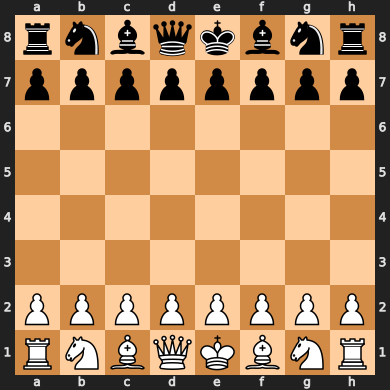

In [421]:
board = first_game.board()
board
# the call to board() will display a visual representation of the board at its current state
# currently no pieces have moved so the result is a beginning board

In [422]:
score = 0
x = 1
for move in first_game.mainline_moves():
    if x == 13:
        # on the occurence of the 14th move (0 index), Stockfish will evaluate the score
        # and move on from the game
        info = sf.analyse(board, chess.engine.Limit(depth=15))
        score = info["score"].relative.score()
        break
    # next move in the pgn for the game
    board.push(move)
    x+=1

In [423]:
# loop through all informational header items of first game
dict = {}
ignore = ["Date", "Round", "ECO", "UTCDate", "UTCTime"]
for head in first_game.headers:
    if head not in ignore:
        dict[head] = first_game.headers[head]

In [424]:
dict.keys()

dict_keys(['Event', 'Site', 'White', 'Black', 'Result', 'BlackElo', 'BlackRatingDiff', 'Opening', 'Termination', 'TimeControl', 'WhiteElo', 'WhiteRatingDiff'])

##### This is a representation of the first game after having been included in the dataframe

In [425]:
df = df.append(dict, ignore_index=True)
df['Eval'] = score
df

,Black,BlackElo,BlackRatingDiff,Event,Opening,Result,Site,Termination,TimeControl,White,WhiteElo,WhiteRatingDiff,Eval
0,lpaulmp,1449,-6,Rated Bullet game,Queen's Gambit Declined: Queen's Knight Variation,1-0,https://lichess.org/ZxvLJH20,Normal,60+0,sisy,1645,+5,123


##### Expanding into the next 5,000 games

As the file analyzed included over 1,000,000 games and was cumbersome to process through and evaluate, we elected to use the first 5,000 games for our analysis.
Even with the necessary plug-ins and files located correctly, the following code block took nearly an hour to complete. It resulted in a 5,002 row data frame in the end, which we briefly modified and passed along to a .csv file for easier analysis in the future.

In [ ]:
count = 0
while count<=5000:
    game = chess.pgn.read_game(pgn)
    board = game.board()
    
    score = 0
    x = 1
    for move in game.mainline_moves():
        if x == 13:
            # on the occurence of the 14th move (0 index), Stockfish will evaluate the score
            # and move on from the game
            info = sf.analyse(board, chess.engine.Limit(depth=15))
            score = info["score"].relative.score()
            break
        # next move
        board.push(move)

        x+=1 
    
    # creates a dictionary to include all of the pgn headers and the stockfish generated evaluation
    header_dict = {"Eval": 0}
    for head in dict.keys():
        if head in game.headers:
            header_dict[head] = game.headers[head]
            
    # appends the game to the data frame and moves on to the following game
    header_dict["Eval"] = score
    df = df.append(header_dict, ignore_index=True)
    
    count+=1

In [215]:
# this data manipulation was ran before the final extraction to .csv
# the code segment cannot be run on the current df object, as there no instances of the replaced cases
# but must be included when running under normal operations
df["Result"].replace(['0-1','1-0','1/2-1/2'], [0,1,2], inplace=True)

##### Saving the data to a .csv and GitHub access

This .csv file will be easier to share and represents all of the useful data and columns following the extraction and Stockfish evaluation. An link to the GitHub upload of the created 5,002 row data frame is available below.

In [ ]:
#df.to_csv(r'chess_Oct_2014.5000.csv', index = False)

#### Following along inside the code can begin HERE

In [29]:
import pandas as pd
# run this segment to begin following along with the code
df = pd.read_csv('https://raw.githubusercontent.com/HubschF/DS3000/main/chess_Oct_2014.5000.csv')
df

,Black,BlackElo,BlackRatingDiff,Event,Opening,Result,Site,Termination,TimeControl,White,WhiteElo,WhiteRatingDiff,Eval,WinElo,EloDiff
0,lpaulmp,1449,-6.0,Rated Bullet game,Queen's Gambit Declined,1,https://lichess.org/ZxvLJH20,Normal,60+0,sisy,1645,5.0,123.0,1449,196
1,ftri67,1672,8.0,Rated Blitz game,French Defense,0,https://lichess.org/1vAdLOmn,Time forfeit,360+0,capablanca1950,1603,-8.0,0.0,1672,-69
2,mike81,1280,-14.0,Rated Bullet game,Queen's Pawn Game,1,https://lichess.org/s1RfrWEQ,Normal,120+1,daamien,1166,42.0,2.0,1280,-114
3,JACKELCALVO,1449,-10.0,Rated Blitz game,French Defense,1,https://lichess.org/4lE9x19F,Normal,180+0,yaavarmo,1494,10.0,8.0,1449,45
4,galita,1285,-12.0,Rated Bullet game,Queen's Gambit Declined,1,https://lichess.org/lVtEXmaA,Time forfeit,60+1,albinofrenchy,1256,20.0,-21.0,1285,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4997,Der_Steppenwolf,1452,-10.0,Rated Blitz game,Ruy Lopez,1,https://lichess.org/ez8YKxl7,Normal,180+3,juanelo333,1459,12.0,15.0,1452,7
4998,dyson,1639,11.0,Rated Classical game,English Opening,0,https://lichess.org/p9MaThOT,Normal,300+8,anatoliy287,1658,-12.0,297.0,1639,19
4999,valdeilton,1681,-8.0,Rated Blitz game,Ruy Lopez,1,https://lichess.org/WZ7Vwn3I,Normal,300+3,Dcollins,1799,8.0,172.0,1681,118
5000,LiyLi,1473,11.0,Rated Classical game,Queen's Gambit Refused,0,https://lichess.org/Tm0P2Qf9,Normal,300+8,pinchacarlos,1471,-11.0,69.0,1473,-2


##### Description of Features

"\[feature_name\]": \[description\]
- "BlackElo": the relative rating of the Black user
- "Event": the type of game being played (time sensitivity)
- "Opening": the name of the opening strategy used in the game
- "Termination": how the game was ended (ex. normal, time forfeit)
- "TimeControl": the variable for alloted time for the game
- "WhiteElo": the relative rating of the White user
- "Eval": the Stockfish calculated evaluation after the opening 7 full moves
- "WinElo": the Elo for the winning player
- "EloDiff": the differential of Elo between White (+) and Black (-)
- "EloBucket": the bin that the winners Elo falls within

### 2.2 Data Analysis

#### Variables

##### Independent Variables (feature variables)

- **BlackElo** rating
- type of chess **Event**
- **Opening** strategy used in the game
- Cause of game **Termination**
- **WhiteElo** rating
- Stockfish **Eval** of the opening advantage
- **WinElo** rating for the winning player
- **EloDiff** between the two players
- **EloBucket** that the winner falls into

##### Dependent Variables (target variables)

- **Result** of the game (0 is a win for Black, 1 is a win for White)


#### Predictive Modeling

In our implementation of predictive models on these variables, we desired to test the Decision Tree, K-Nearest Neighbors, and Gaussian Naïve Bayes Classifiers. In this application, the models exists as a supervised Machine Learning tool.
According to our hypothesis on the relationship between evaluation and victory, we expect to find favorable prediction accuracy scores from the implementation of these Machine Learning Classifiers.

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 3. RESULTS

### 3.1. Data Wrangling

In [5]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder

### Data Cleaning

The data cleaning process included removing elements of some column values, which we deemed too descriptive for analysis, reassigning String values to integers for Machine Learning processing, and the creation of additional columns from existing data to further the depth of our analysis.

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/HubschF/DS3000/main/chess_Oct_2014.5000.csv')

#### Removing ":" and "," in Openings

Lichess provided in depth detail about the opening utilized in each game, including later stage variations, which led to very little comparability across all of the games.  We elected to filter out any trailing variations in the 'Opening' column, by removing elements of the item following that punctuation marks that Lichess included.

In [34]:
def opening_agg(opening):
    if ":" in opening:
        i = opening.index(":")
        opening = opening[:i]
    if "," in opening:
        i = opening.index(",")
        opening = opening[:i]
    return opening

In [35]:
df["Opening"] = df["Opening"].map(opening_agg)

#### Tournament Editing

As some games were played as a part of a Lichess hosted tournament, the exact tournament link was included in the 'Event' feature, and needed to be removed when categorizing like event types. Similarly to the Opening edits, we removed any trailing URLs in the 'Event' column.

In [36]:
def event_agg(event):
    if " https" in event:
        i = event.index(" https")
        event = event[:i]
    return event

In [37]:
df['Event'] = df['Event'].map(event_agg) 

#### Changing Value Types

In the case of some of the data's numerical features, the values were stored as Strings and needed to be converted to integers for comparability.

In [38]:
df["BlackElo"] = df["BlackElo"].map(int)

In [39]:
df["WhiteElo"] = df["WhiteElo"].map(int)

#### Engineering New Features

To have a figure that carried just the winning player's Elo ranking, we created a new column with the 'BlackElo' or 'WhiteElo', depening on the 'Result' value.

In [40]:
def winner_elo(res):
    if res == 1:
        return "WhiteElo"
    else:
        return "BlackElo"

In [41]:
df["WinElo"] = df[df["Result"].map(winner_elo)[0]]

To identify the disparity of Elo ranking between the two competing players, we also derived an 'EloDiff' column, where a positive value designated a higher Elo for White and a negative value indicated Black had a higher Elo

In [42]:
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]

For an easier way of classifying tiers of player Elos, the 'Elo_bucket' was added to assign winners to various bins among the lot of players

In [43]:
elo_bucket = []

for i in df['WinElo']:
    
    count = 0
    x = 0
    y = 200
    
    while count != 1:
        if x <= i <= y:
            elo_bucket.append(y)
            count = 1
        
        else:
            x = y+1
            y += 200

In [44]:
df['Elo_bucket'] = elo_bucket

### Removing Items
#### NA Values

As a few games evaluated to an impending checkmate in the upcoming moves, the Stockfish plugin returned empty values for 'Eval' score. To ensure that these points would not impede our analysis, the few games were removed from consideration

In [45]:
df["Eval"] = df["Eval"].fillna(0)

#### Handling Draws

In some games, the result ended in a draw.  As we did not expect that the models would be accurately able to predict a tie, the instances were also removed from the dataset.

In [46]:
df = df[df["Result"] != 2]

### One-Hot Encoding

As the the Opening and Event type of each game varied, we emplyed a one-hot encoder to create a separate DataFrame that yielded new features for additional model analysis. This DataFrame includes data points for 6 different types of 'Event' and the 149 unique 'Opening' styles used across the games analyzed.

In [47]:
encoder = OneHotEncoder(sparse = False)

one_hot_features = df.iloc[:, 3:5].reset_index(drop=True)

encoded_df = pd.DataFrame(encoder.fit_transform(one_hot_features), columns=encoder.get_feature_names())
encoded_df

,x0_Rated Blitz game,x0_Rated Blitz tournament,x0_Rated Bullet game,x0_Rated Bullet tournament,x0_Rated Classical game,x0_Rated Correspondence game,x1_Alekhine Defense,x1_Amar Opening,x1_Anderssen Opening,x1_Australian Defense,...,x1_Torre Attack #2,x1_Trompowsky Attack,x1_Van Geet Opening,x1_Van't Kruijs Opening,x1_Vienna Game,x1_Vienna Game #2,x1_Ware Defense,x1_Ware Opening,x1_Yusupov-Rubinstein System,x1_Zukertort Opening
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4793,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4794,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2. Data Exploration

In [48]:
fig = px.histogram(df, x= 'Event', color="Termination", title = 'Event Count by Termination Type' )
fig.show()

[Image](https://github.com/HubschF/DS3000/blob/main/newplot.png)

This Bar Graph seeks to understand the way in which indivduals win at the respected event types. Each event corresponds to a time and type of play. To define these games, bullet games are typically games with a minute or less to play. Blitz is typically games between three and five minutes. Classical corresponds to games 10 minutes and greater. Tournament games are typically locked into a set elo. 

Our visualization shows that time to play and wins by time forfeit have an inverse relationship.

In [49]:
fig = px.scatter(df, y="Elo_bucket", x="Eval", color="Result", title = 'Evaluation vs. Elo Trend' )
fig.show()

[Image 2](https://github.com/HubschF/DS3000/blob/main/newplot%20(%232).png)

This scatter plot seeks to understand the relationship between opening evaluation and victory. The variables at work are Elo Bucket, a varible that groups all players into elo ranges that are 200 points big. Another variable is Eval, which evaluates opening advantage in terms of 'centipawns' or percentage of a pawn. It is important to clarify that negative scores for eval are in blacks favor. Finally, points are colored depending on whether they correspond to a win for white or black.

Examing this chart shows promise of a relationship between victory and evaluation. Points tend to show victory based upon the initial advantage. Negateive evaluations favor black victories and the inverse is true for white. It is also important to reconize that has elo bucket rises opening evaluation grows tighter. We presume this means higher level players are less likely to concede opening advantages.

In [50]:
opening_df = pd.DataFrame()

d_openings = {}
for x in df["Opening"]:
    if x in d_openings:
        d_openings[x] += 1
    else:
        d_openings[x] = 1

In [51]:
opening_df['Name'] = d_openings.keys()
opening_df['Times Played'] = d_openings.values()

In [52]:
opening_df = opening_df.sort_values(by= "Times Played", ascending=False).head(15)

In [53]:
for i in opening_df['Name']:
    dict={'Eval':0, 'Elo':0}
    count = 0
    for x in df["Opening"]:
        if i == x:
            dict['Eval'] += df['Eval']
            dict['Elo'] += df['Elo_bucket']
            count += 1 
    opening_df['Avg Eval'] = dict["Eval"]/count
    opening_df['Elo Bucket'] = dict["Elo"]/count

In [54]:
fig = px.scatter(opening_df, x = 'Avg Eval', y = 'Elo Bucket', size="Times Played", color='Name',
                 hover_name ="Name", log_x=True, size_max=60, title = "Most frequent Openings Evaluation")
fig.show()

[Image 3](https://github.com/HubschF/DS3000/blob/main/newplot(%233).png)

This Bubble graph seeks to understand the relationship between openings, average elo bucket and average opening evaluation. Openings correspond to what set of opening theory was used in the opening of the game. The bubbles are set to be sized in accordance to opening popularity. We then reduced the graph to only have the 15 most popular openings. Average evaluation is the average evaluation score after the opening. We then measure these openings by their average elo bucket, or the typical rating of those who play it. 

From this graph we can see most openings reward less than 100 centipawns advantage (or one pawn). We can also see that as as average Elo bucket rises so too does average eval to a point. We are also able to see that most openings, on average, favor white. This can be factored to the starting advantage in chess.  

### 3.3. Model Construction
#### Hypothesis Analysis

With the application of three Machine Learning Classifiers, we set out to predict the outcome of a set of chess games from a testing set. Having trained a model with the training figures of our data, we employed the Decison Tree Classifier, the k-Nearest Neighbors Classifier, and the Gaussian Naïve Bayes Classifier to predict which player would win a chess match.  A strong predctive accuracy would lend itself to answering our primary question:

    Is opening advantage significant in victory in the game of chess?
    
Within the analysis of results, we determined that having a high scoring accuracy in winner prediction, would allow us to reject the null hypothesis (H1, 0), that states that the occurance of an opening advantage does not impact a players ability to win.  The alternative hypothesis (H1, 1) counters this belief, arguing that opening advantage plays into the winning odds of a player.

The secondary hypothesis (H2, 1) carries the belief that using a Decision Tree Classifier would yield the strongest results in predicting winners in chess matches from the included features. Failing to reject the null hypothesis (H2, 0) would mean that Decision Tree classification was not the superior means of predicting winners.

In our testing, we utilized the main five features that carried quantifiable weight on a chess match. These were the following:
- 'WinElo'
- 'EloDiff'
- 'WhiteElo'
- 'BlackElo'
- 'Eval'

A secondary data frame was also constructed to include the 'Opening' and 'Event' features, which had been one-hot encoded for analyzing repeated String values.

In [55]:
def features_and_target(df):
    features = pd.DataFrame()
    target = df['Result']
    #creating features df of the numeric features to assess in model
    for x in ["WinElo", "EloDiff","WhiteElo", "BlackElo", "Eval"]:
        features[x] = df[x]
    return features, target

In [56]:
features, target = features_and_target(df)

features indexes had to be reset to ensure joining with built_df on index values was seamless.

In [57]:
features.reset_index(drop=True, inplace=True)
features

,WinElo,EloDiff,WhiteElo,BlackElo,Eval
0,1645,196,1645,1449,123.0
1,1603,-69,1603,1672,0.0
2,1166,-114,1166,1280,2.0
3,1494,45,1494,1449,8.0
4,1256,-29,1256,1285,-21.0
...,...,...,...,...,...
4792,1459,7,1459,1452,15.0
4793,1658,19,1658,1639,297.0
4794,1799,118,1799,1681,172.0
4795,1471,-2,1471,1473,69.0


In [58]:
target

0       1
1       0
2       1
3       1
4       1
       ..
4997    1
4998    0
4999    1
5000    0
5001    0
Name: Result, Length: 4797, dtype: int64

The built_df joins features and the one-hot encoded encoded_df on like indices for deeper analysis including the exact Opening employed and Event type played in.

In [59]:
built_df = features.join(encoded_df)
built_df

,WinElo,EloDiff,WhiteElo,BlackElo,Eval,x0_Rated Blitz game,x0_Rated Blitz tournament,x0_Rated Bullet game,x0_Rated Bullet tournament,x0_Rated Classical game,...,x1_Torre Attack #2,x1_Trompowsky Attack,x1_Van Geet Opening,x1_Van't Kruijs Opening,x1_Vienna Game,x1_Vienna Game #2,x1_Ware Defense,x1_Ware Opening,x1_Yusupov-Rubinstein System,x1_Zukertort Opening
0,1645,196,1645,1449,123.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1603,-69,1603,1672,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1166,-114,1166,1280,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1494,45,1494,1449,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1256,-29,1256,1285,-21.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,1459,7,1459,1452,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4793,1658,19,1658,1639,297.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4794,1799,118,1799,1681,172.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4795,1471,-2,1471,1473,69.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

evaluators = {
    "Decison Tree" : DecisionTreeClassifier(max_depth=5),
    "k-Nearest Neighbor" : KNeighborsClassifier(),
    "Gaussian Naive Bayes" : GaussianNB()}

In [61]:
print("WITHOUT the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
for eval_name, eval_obj in evaluators.items():
    
    model = eval_obj.fit(X=X_train, y=y_train)
    
    print(eval_name + ":")
    print("\tPrediction accuracy on the training data:", f"{model.score(X_train, y_train):.2%}")
    print("\tPrediction accuracy on the test data:", f"{model.score(X_test, y_test):.2%}","\n")

print("-"*25 + "\n\nWITH the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(built_df, target, random_state=3000)
for eval_name, eval_obj in evaluators.items():
    
    model = eval_obj.fit(X=X_train, y=y_train)
    
    print(eval_name + ":")
    print("\tPrediction accuracy on the training data:", f"{model.score(X_train, y_train):.2%}")
    print("\tPrediction accuracy on the test data:", f"{model.score(X_test, y_test):.2%}","\n")

WITHOUT the one-hot encoded 'Openings' and 'Events':

Decison Tree:
	Prediction accuracy on the training data: 68.25%
	Prediction accuracy on the test data: 64.42% 

k-Nearest Neighbor:
	Prediction accuracy on the training data: 73.76%
	Prediction accuracy on the test data: 61.08% 

Gaussian Naive Bayes:
	Prediction accuracy on the training data: 66.08%
	Prediction accuracy on the test data: 64.42% 

-------------------------

WITH the one-hot encoded 'Openings' and 'Events':

Decison Tree:
	Prediction accuracy on the training data: 68.17%
	Prediction accuracy on the test data: 63.25% 

k-Nearest Neighbor:
	Prediction accuracy on the training data: 73.78%
	Prediction accuracy on the test data: 61.08% 

Gaussian Naive Bayes:
	Prediction accuracy on the training data: 54.16%
	Prediction accuracy on the test data: 53.33% 



### 3.4. Model Evaluation
##### Model Performance
As displayed in the above calculations, we see a prediction accuracy above 50% for all classifiers, suggesting that evaluation and elo play into winner prediction since the games are significantly above a random chance esimate that would be expected in a fair chess match.

For the basic features data frame without including the Opening and Event encoded features, the k-Nearest Neighbors appears to rank supreme in its accuracy on training data (73.76%), although it ranks lowest in testing accuracy (61.08%).  This disparity could suggest that the data is overfit to the training data. KNN classification accuracy on training narrowly rose to 73.78%, but remained unchanged on training accuracy.

Overall, Decision Tree classification yielded a favorable 68.25% training accuracy and 64.24% testing accuracy for the simple data frame, and only slightly fell in accuracy to 68.17% and 63.25% with the expanded data.

On the expanded data frame, the results remain consistently similar for Decision Tree and KNN Classifiers, but drops nearly 10% in accuracy for the Guassian Naïve Bayes Classifier. Initital training accuracy is 66.08% while testing is 64.42% in the simple data frame, while the expanded data lowers each to 54.16% and 53.33%, respectively. For this reason, we selected to continue on our analysis with only the **Decision Tree** and **k-Nearest Neighbors Classifiers**.

### 3.5. Model Optimization

##### Isolating the Best Models

To prevent a risk of overfitting our data to the training set, we tuned the parameters of the selected classifiers with a grid search evaluation.

The results of our grid search indicated which paramters would be best included to fairly evaluate our hypotheses in our final stage of hypothesis testing.

##### Hyperparameter Tuning

In [66]:
from sklearn.model_selection import GridSearchCV

grid_evaluators = {
    "Decision Tree" : [DecisionTreeClassifier(), {"max_depth" : list(range(1,13))}],
    "k-Nearest Neighbor" : [KNeighborsClassifier(), {"n_neighbors" : list(range(3,13))}]}

In [67]:
print("WITHOUT the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
for eval_name, eval_list in grid_evaluators.items():
    grid_search = GridSearchCV(eval_list[0], eval_list[1], cv=5)
    grid_search.fit(X=X_train, y=y_train)
    print(eval_name + ":")
    print("\tBest cross-validation score: ", grid_search.best_score_)
    print("\tBest parameters: ", grid_search.best_params_,"\n")
    
print("-"*25 + "\n\nWITH the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(built_df, target, random_state=3000)
for eval_name, eval_list in grid_evaluators.items():
    grid_search = GridSearchCV(eval_list[0], eval_list[1], cv=5)
    grid_search.fit(X=X_train, y=y_train)
    print(eval_name + ":")
    print("\tBest cross-validation score: ", grid_search.best_score_)
    print("\tBest parameters: ", grid_search.best_params_,"\n")

WITHOUT the one-hot encoded 'Openings' and 'Events':

Decision Tree:
	Best cross-validation score:  0.6563834801421728
	Best parameters:  {'max_depth': 6} 

k-Nearest Neighbor:
	Best cross-validation score:  0.629410060268892
	Best parameters:  {'n_neighbors': 11} 

-------------------------

WITH the one-hot encoded 'Openings' and 'Events':

Decision Tree:
	Best cross-validation score:  0.6549903415237213
	Best parameters:  {'max_depth': 3} 

k-Nearest Neighbor:
	Best cross-validation score:  0.629410060268892
	Best parameters:  {'n_neighbors': 11} 



### 3.6. Model Testing

In [68]:
from sklearn.metrics import classification_report

In [69]:
# the values in the dictionaries are in a list so that different parameters could be used while
# iterating over both data frames and both evaluators
test_evaluators = {
    "Decison Tree" : [DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=3)],
    "k-Nearest Neighbor" : [KNeighborsClassifier(n_neighbors=11),KNeighborsClassifier(n_neighbors=11)]}

In [70]:
print("WITHOUT the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
for eval_name, eval_obj in test_evaluators.items():
    
    model = eval_obj[0].fit(X=X_train, y=y_train)
    
    print(eval_name + ":")
    print("\tPrediction accuracy on the training data:", f"{model.score(X_train, y_train):.2%}")
    print("\tPrediction accuracy on the test data:", f"{model.score(X_test, y_test):.2%}")
    print(classification_report(y_true=y_test, y_pred=eval_obj[0].predict(X=X_test)))

print("-"*25 + "\n\nWITH the one-hot encoded 'Openings' and 'Events':\n")
X_train, X_test, y_train, y_test = train_test_split(built_df, target, random_state=3000)
for eval_name, eval_obj in test_evaluators.items():
    
    model = eval_obj[1].fit(X=X_train, y=y_train)
    
    print(eval_name + ":")
    print("\tPrediction accuracy on the training data:", f"{model.score(X_train, y_train):.2%}")
    print("\tPrediction accuracy on the test data:", f"{model.score(X_test, y_test):.2%}")
    print(classification_report(y_true=y_test, y_pred=eval_obj[1].predict(X=X_test)))

WITHOUT the one-hot encoded 'Openings' and 'Events':

Decison Tree:
	Prediction accuracy on the training data: 68.97%
	Prediction accuracy on the test data: 63.25%
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       579
           1       0.63      0.72      0.67       621

    accuracy                           0.63      1200
   macro avg       0.63      0.63      0.63      1200
weighted avg       0.63      0.63      0.63      1200

k-Nearest Neighbor:
	Prediction accuracy on the training data: 70.14%
	Prediction accuracy on the test data: 63.75%
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       579
           1       0.65      0.65      0.65       621

    accuracy                           0.64      1200
   macro avg       0.64      0.64      0.64      1200
weighted avg       0.64      0.64      0.64      1200

-------------------------

WITH the one-hot encoded 'Openings' and

<a id="4"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 4. DISCUSSION

#### Summary 

After extracting data from the Lichess.org database, we processed through each game and evaluated the scoring advantage at move 14 with the chess analysis engine, Stockfish. From there we defined our features, event, respective player elo, elo difference, termination, and opening. We set our target as the game result, as we attempted to see if we could predict victory with our models. We then used a one-hot encoder to include the opening and event type features, which had varied greatly among the games.  

From there we attempted to see which algorithm best predicted victory from our data. We attempted a decision tree classifier, a KNN classifier, and a Gaussian Naïve Bayes classifier. Without one-hot encoded features, we found that the decision tree classifier preformed best. With one-hot encoded features included, we found that decision tree classifier continued to perform the best of the three, with only the Gaussian Naïve Bayes model decreasing in accuracy. Decision tree and KNN stayed very close to the same outputs, both producing results in the high 60% to low 70% range on training data and low 60%s on the testing data.

We then sought to optimize our results by using a grid search to tune the parameters best suited our dataset. When testing grid search we found that it improved the performance of our algorithms and resulted in KNN being slightly better than decision tree.  We can conclude here that KNN and Decision Tree are the best tools for this work. Using KNN with gridsearch we found we now had a prediction accuracy of 63.75.  

When seeking to examine if our findings where statistically significant we derived an F-1 score. We found an accuracy of .64, statistically significant. From here we can also conclude that features such as eval and elo ranking are predictive of result.  

#### Hypothesis 

Is opening advantage significant in victory in the game of chess? 

* With a .64 f1 score successfully reject the null and conclude that opening advantage is significant in the game of chess.

Is the Decision Tree Classifier the optimal classifier for predicting match result? 

* With the results for KNN being equal to Decision Tree Classification in our hypothesis testing, we fail to reject the null hypothesis and can conclude that Decision Tree is not the most effective Machine Learning Classifier to predict winning from opening evaluations.  

Will testing better players change the significance of opening advantage?  

* We fail to reject the null and conclude that better players change the significance of opening advantage.  

#### Conclusion  

To concluded we have done valuable work by confirming, with data, the effects of opening evaluation on victory. We found that by factoring in these features we could predict the victory with reasonable accuracy. In the future, researcher might use type of victory to better predict results. As not all games are won by checkmate, some are won by running out of time. Adding a different method of target might help conclude different results. 

<a id="5"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

### CONTRIBUTIONS
The completion of this research, analysis, and discovery is the product of a joint effort by both authors, Fletcher Hubsch and Charlie Morgan, through the course of the Fall 2020 Academic Semester. Several tasks were completed through virtual meetings, and the end product is reflective of this joint effort.

In the case of individual work contributions, Mr. Hubsch had more responsibility with the theory, hypothesization, and visualization of inferential discovery from our data, due to his strong background in the field.  Mr. Morgan was responsible for a greater portion of the data wrangling and model testing due to the nature of the dataset being more optimally processed and evaluated through his machine.